# TODO

- Aggiungere descrizione e motivazione di tutti i passaggi

# Preprocess pictures for training

## Imports

In [1]:
import cv2 as cv
import os
import numpy as np
from tqdm.notebook import tqdm
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib
import matplotlib.pyplot as plt

In [2]:
import utils_2d

## Dlib detector and predictor

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

## Preprocessing Steps

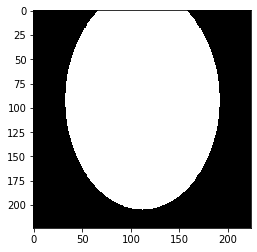

In [7]:
mask = utils_2d.create_mask()
plt.imshow(mask, cmap="gray")
plt.show()

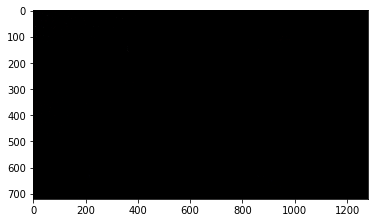

In [8]:
img = utils_2d.take_bgr_picture()
plt.imshow(img[:,:,::-1])
plt.show()

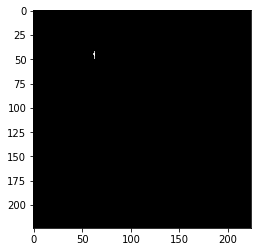

In [9]:
processed_face = utils_2d.preprocess_img(img, mask, 200, detector, fa)
plt.imshow(processed_face, cmap="gray")
plt.show()

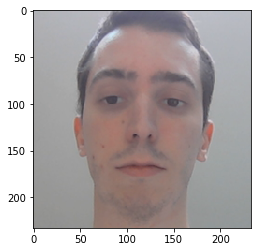

In [10]:
img = cv.imread("pictures_new/gian/gian_600.png")
plt.imshow(img[:,:,::-1])
plt.show()

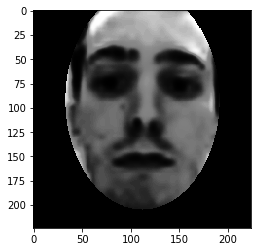

In [11]:
plt.imshow(utils_2d.preprocess_img(img, mask, 50, detector, fa), cmap="gray")
plt.show()

## Apply preprocessing function to saved pictures

In [17]:
# might take a while depending on how much the picture is resized before being aligned with dlib
srcdir = "pictures_new/"
outdir = "pictures_masked_resized/"
new_width=50

for name in os.listdir(srcdir): # or choose the folders of interest

    indir = srcdir+name
    destdir = outdir+name
    
    print(f"Preprocessing pictures in {indir}\nSaving the preprocessed pictures to {destdir}")
    
    os.makedirs(destdir, exist_ok=True)
    
    for file in tqdm(os.listdir(indir)):

        img = cv.imread(indir+"/"+file)
        
        prep_img = utils_2d.preprocess_img(img, mask, new_width, detector, fa)
        
        cv.imwrite(destdir+"/"+file, prep_img)


Preprocessing pictures in pictures_new/papi
Saving the preprocessed pictures to pictures_masked_resized/papi



Preprocessing pictures in pictures_new/luca
Saving the preprocessed pictures to pictures_masked_resized/luca



Preprocessing pictures in pictures_new/mamma
Saving the preprocessed pictures to pictures_masked_resized/mamma



Preprocessing pictures in pictures_new/alinda
Saving the preprocessed pictures to pictures_masked_resized/alinda



Preprocessing pictures in pictures_new/khaled
Saving the preprocessed pictures to pictures_masked_resized/khaled



Preprocessing pictures in pictures_new/cami
Saving the preprocessed pictures to pictures_masked_resized/cami



Preprocessing pictures in pictures_new/gian
Saving the preprocessed pictures to pictures_masked_resized/gian



Preprocessing pictures in pictures_new/alessandro
Saving the preprocessed pictures to pictures_masked_resized/alessandro


# Move pictures to train/val/test folders

In [18]:
root_dir = 'pictures_masked_resized'
dest_dir = 'pictures_masked_resized_split' # or the same as root_dir

In [19]:
utils_2d.pictures_train_test_val_split(root_dir, dest_dir, verbose=True)

Current class: papi
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: luca
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: mamma
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: alinda
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: khaled
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: cami
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: gian
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: alessandro
Total images: 459
Training: 321
Validation: 92
Testing: 46



# Eyes (tests for the future)

In [10]:
img = utils_2d.take_bgr_picture()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
faces = detector(gray, 1)

Might be interesting to see if we can obtain better results by adding a feature involving the eyes. The eyes' color might help the models.

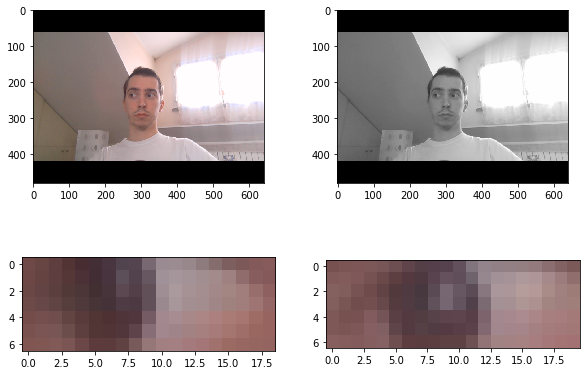

In [11]:
utils_2d.plot_eyes(img, faces, predictor, gray)